# Introduction
This is a Graph Convolutional Networks (GCN) to predict adsorption energy by density of states of mentals.

# Function

In [278]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
import numpy as np
import pickle

import spektral

from spektral.data import Dataset,Graph

from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Dense
from tensorflow.keras.layers import AveragePooling1D, Concatenate, Conv1D, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from spektral.data import DisjointLoader
from spektral import models
from spektral.layers import ECCConv, GlobalSumPool, GlobalAvgPool

import pandas

In [279]:
import sys
sys.executable

'/home/zwbai/miniconda3/envs/gcn/bin/python'

In [280]:
tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())

True


# Load Data

In [281]:
class MyGraphDataset(Dataset):
    """
    A dataset of density of states of mentals
    """
    def __init__(self, graph_list, **kwargs):
        self.graph_list = graph_list
        super().__init__(**kwargs)
    
    def download(self):
        if self.path is None:
            print('self.path is None')
        else:
            with open(self.path, 'wb') as file:
                pickle.dump(self.graph_list, file)

    def read(self):
        # We must return a list of Graph objects
        output = []
        for i in range(len(self.graph_list)):
            output.append(
                self.graph_list[i]
            )
        return output

    def __len__(self):
        return len(self.graph_list)

    def __getitem__(self, index):
        return self.graph_list[index]

In [282]:
# 从文件中提取数据
folder_path_all = '/media/zwbai/DATA/dft/shear/' # 当前文件执行的文件夹，包括输出和输入文件夹
output_path = folder_path_all + 'output/'
dos_energy_data_file = output_path + 'dos_energy_data.pkl'
with open(dos_energy_data_file, 'rb') as file:
    dataset1 = pickle.load(file)

print(dataset1)  # 输出：[1, 2, 3, 4, 5]
dataset1[0].x.shape

MyGraphDataset(n_graphs=120)


(8, 2000)

In [283]:
# 从文件中提取数据
file_path = '/media/zwbai/DATA/dft/new_Cu_tc/dos_energy_data.pkl'
with open(file_path, 'rb') as file:
    dataset2 = pickle.load(file)

print(dataset2)  # 输出：[1, 2, 3, 4, 5]
dataset2[0].x.shape

MyGraphDataset(n_graphs=126)


(8, 2000)

In [284]:
graph_data = []
for i in range(len(dataset1)):
    g = dataset1[i]
    graph_data.append(g)
for i in range(len(dataset2)):
    g = dataset2[i]
    graph_data.append(g)
len(graph_data)


246

In [285]:
dataset = MyGraphDataset(graph_data)

In [286]:
dataset[200]

Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1)

# Build GCN model

In [287]:
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target
F, S, n_out

(2000, 4, 1)

In [288]:
print(dataset.n_nodes)

None


In [289]:
learning_rate = 1e-3  # Learning rate
epochs = 40  # Number of training epochs
batch_size = 5  # Batch size


In [290]:
def dos_featurize(length, channel):
    input_dos = Input(shape=(length, channel)) # 400, 5
    x1 = AveragePooling1D(pool_size=2, strides=2, padding='same')(input_dos)  # 窗口 步长
    x2 = AveragePooling1D(pool_size=4, strides=2, padding='same')(input_dos)
    x3 = AveragePooling1D(pool_size=8, strides=2, padding='same')(input_dos)
    x = Concatenate(axis=-1)([x1, x2, x3])  # 沿着最后一个轴拼接
    x = Conv1D(250, 9, activation='relu', padding='same', strides=2)(x)
    x = BatchNormalization()(x)
    x = Conv1D(175, 3, activation='relu', padding='same', strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding='same')(x)
    x = Conv1D(150, 3, activation='relu', padding='same', strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding='same')(x)
    x = Conv1D(125, 3, activation='relu', padding='same', strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding='same')(x)
    x = Conv1D(100, 3, activation='relu', padding='same', strides=2)(x)
    x = tf.squeeze(x)
    # x = x.numpy()
    shared_model = Model(input_dos, x)
    return shared_model

channels = 5
length = int(F/channels) # 400
shared_conv = dos_featurize(length, channels)

In [291]:
dataset_tr = MyGraphDataset(dataset[:66])
loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs)
print(loader_tr.tf_signature())
for batch in loader_tr:
    print(batch[0][0].shape) # batch[0~3] 有四个属性

((TensorSpec(shape=(None, 2000), dtype=tf.float64, name=None), SparseTensorSpec(TensorShape([None, None]), tf.float32), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(8, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(8, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(8, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(8, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000)
(40, 2000

In [292]:
batch[0][0].shape

(8, 2000)

# 

In [293]:
def get_range(lst, ran=[0,1], per_batch=8):
    # 分割
    return (np.array([item for i in range(0, len(lst), per_batch) for item in lst[i+ran[0]:i+ran[1]]]))

def repeat_and_stack(matrix, repeat_times=6):
    # 扩展
    m0 = tf.reshape(matrix, [-1, 1, matrix.shape[-1]])
    m1 = tf.tile(m0, [1, repeat_times, 1])
    m2 = tf.reshape(m1, [-1, matrix.shape[-1]])
    return m2

def assemble(lst, ran=6, per_batch=8):
    # 装配
    lst0 = tf.reshape(lst, [-1, ran, lst.shape[-1]])
    padded_matrix = tf.pad(lst0, [[0, 0], [0, per_batch-ran], [0, 0]])
    padded_matrix = tf.reshape(padded_matrix, [-1, lst.shape[-1]])
    return padded_matrix

In [294]:
x = batch[0][0]
x.shape

(8, 2000)

In [295]:
x0 = get_range(x)
x0.shape

(1, 2000)

In [296]:
x1 = tf.reshape(x0,(-1, length, channels))
x1.shape

TensorShape([1, 400, 5])

In [297]:
x2 = shared_conv(x1)
# x1 = x1.numpy()
x2.shape

TensorShape([100])

In [298]:
x6 = repeat_and_stack(x2)
x8 = assemble(x6)
x8.shape

TensorShape([8, 100])

In [299]:
x8.shape

TensorShape([8, 100])

In [300]:
class Net(Model):
    def __init__(self):
        super().__init__()
        self.share = shared_conv
        self.conv1 = ECCConv(64, activation="relu")
        self.conv2 = ECCConv(64, activation="relu")
        # self.conv3 = ECCConv(128, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = tf.reshape(x, (-1, length, channels))
        x1 = get_range(x)
        x1 = shared_conv(x1)
        x6 = repeat_and_stack(x1)
        x = assemble(x6)
        
        x = self.conv1([x, a, e])
        x = self.conv2([x, a, e])
        # x = self.conv3([x, a, e])
        output = self.global_pool([x, i])
        output = self.dense(output)

        return output

In [301]:
model = Net()
learning_rate = 1E-3
optimizer = Adam(learning_rate)
loss_fn = MeanSquaredError()

dataset_tr = MyGraphDataset(dataset)
loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs)

In [302]:
# Fit model
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [303]:
model.layers

In [304]:
step = loss = 0
for batch in loader_tr:
    step += 1
    loss += train_step(*batch)
    if step == loader_tr.steps_per_epoch:
        step = 0
        print("Loss: {}".format(loss / loader_tr.steps_per_epoch))
        loss = 0

Loss: 0.22252574563026428
Loss: 0.264910489320755
Loss: 0.21615153551101685
Loss: 0.1899760216474533
Loss: 0.12542174756526947
Loss: 0.0775722861289978
Loss: 0.06698441505432129
Loss: 0.059383440762758255
Loss: 0.05314004793763161
Loss: 0.04339081794023514
Loss: 0.04953073337674141
Loss: 0.019653255119919777
Loss: 0.034301888197660446
Loss: 0.02313479408621788
Loss: 0.010719277895987034
Loss: 0.008630596101284027
Loss: 0.009938289411365986
Loss: 0.0236440971493721
Loss: 0.020420528948307037
Loss: 0.02485540136694908
Loss: 0.00972296204417944
Loss: 0.03197043016552925
Loss: 0.032050300389528275
Loss: 0.025352468714118004
Loss: 0.034232720732688904
Loss: 0.044087447226047516
Loss: 0.043394070118665695
Loss: 0.007589653600007296
Loss: 0.00404737563803792
Loss: 0.004517069552093744
Loss: 0.004072098061442375
Loss: 0.010385903529822826
Loss: 0.004971626680344343
Loss: 0.010421164333820343
Loss: 0.008133303374052048
Loss: 0.014841336756944656
Loss: 0.009156572632491589
Loss: 0.01138254161924

In [305]:
model.summary()

Model: "net_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_8 (Functional)         None                      339300    
_________________________________________________________________
ecc_conv_16 (ECCConv)        multiple                  38464     
_________________________________________________________________
ecc_conv_17 (ECCConv)        multiple                  24640     
_________________________________________________________________
global_avg_pool_8 (GlobalAvg multiple                  0         
_________________________________________________________________
dense_8 (Dense)              multiple                  65        
Total params: 402,469
Trainable params: 401,969
Non-trainable params: 500
_________________________________________________________________


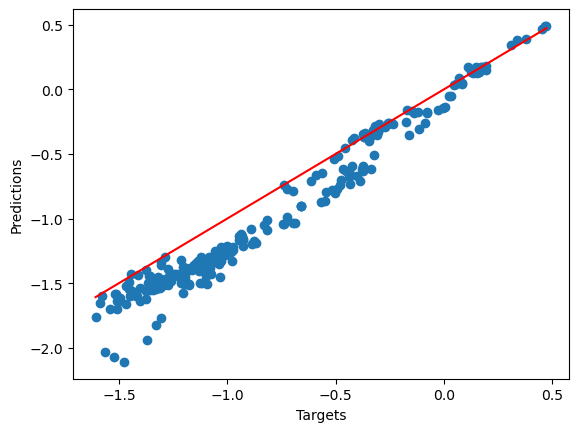

In [306]:

# dataset_tr = dataset
loader_tr = DisjointLoader(dataset_tr, batch_size=1,epochs=1)
# 对整个数据集进行预测
predictions = []
targets = []
for batch in loader_tr:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

# 组合预测值和真实值
data = np.concatenate([predictions, targets], axis=1)

# 画图
import matplotlib.pyplot as plt
plt.scatter(data[:, 1], data[:, 0])

plt.plot([min(data[:, 1]),max(data[:, 1])],[min(data[:, 1]),max(data[:, 1])], color = 'red' )
plt.xlabel("Targets")
plt.ylabel("Predictions") 

plt.show()